<a href="https://colab.research.google.com/github/pao0318/HandsonML/blob/main/SVM_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Support Vector Machines**
In this notebiook I will be building a **Support Vector Machine** for **classificatio**n using **scikit-learn** and the **Radial Basis Function(RBF) kernel**. Our training data set contains continuous and categorical data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) to predict whether or not a person will [default on their credit card](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients/).

# Importing the modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample #downsample the dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.decomposition import PCA

# Importing the data
Now we load dataset. Credit Card Default dataset. This dataset will allow us to predict if someone will default on their credit card based on their sex,age and vaiety of other features.

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/dataset/default of credit card clients.xls',header=1)

Now as we have loaded the dataset let's look at the data head

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Lets rename the last column

In [ ]:
df.rename({'default payment next month':'DEFAULT'},axis='columns',inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Also the value in **ID** column were randomly assigned so we have to drop it

In [ ]:
df.drop('ID',axis=1,inplace=True)


# Now we have to inspect and deal with all the missing data

### 1.Identifying the missing data

In [ ]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

Lets start by making sure **SEX** only contains the numbers 1 and 2

In [ ]:
df['SEX'].unique()

array([2, 1])

Lets look at the **Education**

In [ ]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

So on addition it also containsn 0,5,6. It is possible that 0 represents missing data and 5,6 represents categories not mentioned in specification.
Now lets look at **MARRIAGE**.

In [ ]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0])

We can assume 0 can be a missing data

### 2.Dealing with the missing data
We can either delete it or impute value for the missing data. Lets see how many rows contain missing value

In [ ]:
len(df.loc[(df['EDUCATION']==0)|(df['MARRIAGE']==0)])

68

In [ ]:
len(df)

30000

So **68** out of **30000** rows or less than **1%** contain missing value. So we can remove the rows with missing values.

In [ ]:
df_updated=df.loc[(df['EDUCATION']!=0)& (df['MARRIAGE']!=0)]

In [ ]:
len(df_updated)

29932

In [ ]:
df_updated['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6])

In [ ]:
df_updated['MARRIAGE'].unique()

array([1, 2, 3])

# **Downsample the data**
**Support Vector Machines** are great with small amount of dataset, but not with huge as it takes long time to optimize with **Cross Validation**. So we will downsample both the categories:- default and notdefault, to 1000 each.

In [ ]:
len(df_updated)

29932

To get 1000 of each category we start by splitting the dataframes

In [ ]:
df_no_default=df_updated[df_updated['DEFAULT']==0]
df_default=df_updated[df_updated['DEFAULT']==1]

In [ ]:
df_no_default_down=resample(df_no_default,replace=False,
                            n_samples=1000,random_state=42)

In [ ]:
df_default_down=resample(df_default,replace=False,
                            n_samples=1000,random_state=42)

In [ ]:
len(df_no_default_down)

1000

Now **merg**e the two downsampled datasets into a single dataframe

In [ ]:
df_downsampled=pd.concat([df_no_default_down,df_default_down])
len(df_downsampled)

2000

# **Format Data Part 1: Split the Data into Dependent and Independent Variables**
Split the data into two parts:

1. The columns to use for classification
2. The columns of data that we want to predict


In [ ]:
X=df_downsampled.drop('DEFAULT',axis=1).copy() #df_no_default[:,:,-1].copy
y=df_downsampled['DEFAULT'].copy()

In [ ]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,-2,100143,50456,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,0,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,0,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,-2,355,975,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,0,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [ ]:
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

# **Format Data Part 2: One-Hot Encoding**
There can be two ways:
1.   Column Transformer
2.   get_dummies
SEX EDUCATION MARRIAGE and PAY are supposed to be categorical data and need to be modified.




## Column Transformer

In [ ]:
pd.get_dummies(X,columns=['MARRIAGE']).head()

,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,130000,2,3,28,0,0,0,0,-2,-2,100143,50456,50000,0,0,0,2500,1000,0,0,0,0,1,0,0
4678,170000,1,3,29,0,0,0,0,0,0,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,180000,2,2,29,0,0,0,0,0,0,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,210000,2,2,32,-2,-2,-2,-2,-2,-2,355,975,410,0,0,0,979,412,0,0,0,0,0,1,0
17535,190000,2,3,45,0,0,0,0,0,0,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000,1,0,0


In [ ]:
X_encoded=pd.get_dummies(X,columns=['SEX',
                                    'EDUCATION','MARRIAGE','PAY_0',
                                    'PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,...,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_7,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,1500,1056,950,1000,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# **Format Data Part 3:Centering and Scaling**
There can be two ways:
1.   Column Transformer
2.   get_dummies
SEX EDUCATION MARRIAGE and PAY are supposed to be categorical data and need to be modified.

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_encoded,y,random_state=42)
X_train_scaled=scale(X_train)
X_test_scaled=scale(X_test)

# **Build a Preliminary Support Vector Machine**

In [ ]:
clf_svm=SVC(random_state=42)
clf_svm.fit(X_train_scaled,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

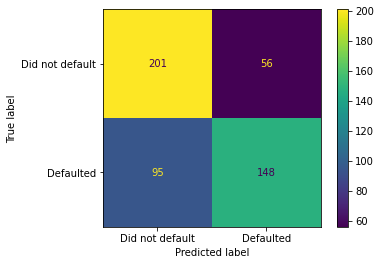

In [ ]:
plot_confusion_matrix(clf_svm,X_test_scaled,y_test,
                      values_format='d',
                      display_labels=["Did not default","Defaulted"])

We see that 79% who didnot default were correctly classified and those who defaulted were 61% correctly classified.So lets try to improve prediction using Cross Validation to optimize parameters

# **Optimize Parameters with Cross Validation and GridSearchCV()**

In [ ]:
param_grid=[
            {'C':[0.5,1,10,100],
             'gamma':[1,0.1,0.01,0.0001],
             'kernel':['rbf']
            },
]

optimal_params=GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0
)
optimal_params.fit(X_train_scaled,y_train)
print(optimal_params.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


# **Building, Evaluating, Drawing and Interpreting the Final Support Vector Machine**

In [ ]:
clf_svm=SVC(random_state=42,C=1,gamma=0.01)
clf_svm.fit(X_train_scaled,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

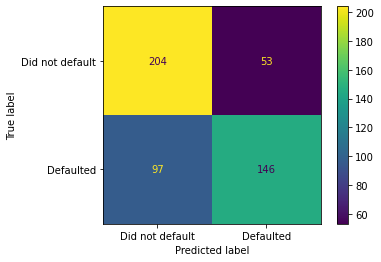

In [ ]:
plot_confusion_matrix(clf_svm,X_test_scaled,y_test,
                      values_format='d',
                      display_labels=["Did not default","Defaulted"])

Got just little better

In [ ]:
len(df_downsampled.columns)

24

24 is quite a lot of features as it would require a 24-Dimensional graph to make prediction. We will use **PCA** to combine 24 features into 2 orthogonal meta-features

In [ ]:
pca=PCA()
X_train_pca=pca.fit_transform(X_train_scaled)
